In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import math
import pandas
from sklearn.cluster import KMeans
from sklearn import decomposition
import scipy.stats
import scipy.signal as signal
from sklearn.neighbors import KDTree
import csv
import seaborn as sns

In [2]:
def plot(x,filename,ymin):
    x_set = np.arange(0, len(x[0]), 1)
    labels1 = []
    plt.ylim((ymin,1))
    plt.xlabel("Node")
    plt.ylabel("Similarity")
    plt.plot(x_set, x[0], 'b', linewidth=1.5)
    labels1.append(r'Aligned ')
    plt.plot(x_set, x[1], 'g', linewidth=1.5)
    labels1.append(r'Source Average ')
    plt.plot(x_set, x[2], 'r', linewidth=1.5)
    labels1.append(r'Target Average ')
    plt.legend(labels1, ncol=4, loc='upper right',
               bbox_to_anchor=[1, 0.12],
               columnspacing=1.0, labelspacing=0.2,
               handletextpad=0.2, handlelength=1.5,
               fancybox=True, shadow=True)
    plt.savefig(filename,dpi=500)
    plt.show()

In [3]:
def loadData(filename,sample_frequency):
    data = filename#np.load(filename)#nodes,timestamp
    days=min(7,math.floor(data.shape[1]/sample_frequency))
    Y = np.array(data[ :, 0:days*sample_frequency])
    Y_re=Y.reshape([-1,days,sample_frequency])#nodes,days,samples
    Y_sum=Y_re.sum(axis=1)
    Y_nz=np.count_nonzero(Y_re, axis=1)
    Y_nz[Y_nz == 0] = 1
    Y_mean=Y_sum/Y_nz
    return Y_mean #node, fre

In [4]:
def fre_uni(datax,datay):
    frex=datax.shape[1]
    n_tar = signal.resample(datay.T, frex)
    return datax,n_tar.T

In [5]:
def timestamp_alignment(datax,datay,TA=0):
    #print(datax.shape,'dataxshape') node,samples
    x_nz = np.count_nonzero(datax, axis=0)
    y_nz = np.count_nonzero(datay, axis=0)
    x_nz[x_nz == 0] = 1
    y_nz[y_nz == 0] = 1
    x_sum = datax.sum(axis=0)
    y_sum = datay.sum(axis=0)
    mean_sequence_x=x_sum/x_nz
    mean_sequence_y = y_sum / y_nz
    pos_t=np.where((datax == 0))
    datax[pos_t] = mean_sequence_x[pos_t[1]]
    pos_s = np.where((datay == 0))
    datay[pos_s] = mean_sequence_y[pos_s[1]]
    
    if TA:
        mark_x=np.argmin(mean_sequence_x)
        mark_y = np.argmin(mean_sequence_y)
        x_a,x_b=datax.T[0:mark_x],datax.T[mark_x:]
        y_a, y_b = datay.T[0:mark_y], datay.T[mark_y:]
        datax=np.append(x_b,x_a,axis=0).T
        datay = np.append(y_b, y_a,axis=0).T
    
    return datax,datay

In [6]:
def Simcaculate(x,y):
    Sim = []
    for i in range(len(x)):
        s = []
        for j in range(len(y)):
            KL = np.exp(-scipy.stats.entropy(x[i], y[j]))
            s.append(KL)
            if np.isnan(KL):
                print("Attention!!")
        Sim.append(np.mean(s))
    Sim = np.mean(Sim)
    return Sim

In [7]:
def moving_average(interval, windowsize,mark):
    if mark==1:
        re = np.ndarray(interval.shape)
        interval=interval.T
        interval = np.concatenate((interval, np.tile(interval[[-1],:], (windowsize - 1,1))),axis=0).T
        for i in range(interval.shape[0]):
            window = np.ones(int(windowsize)) / float(windowsize)
            convRe= np.convolve(interval[i], window, 'valid')
            re[i]=convRe
    else:
        interval = np.hstack((interval, np.tile(interval[[-1]], windowsize - 1)))
        window = np.ones(int(windowsize)) / float(windowsize)
        re = np.convolve(interval, window, 'valid')
    return re

In [8]:
class Graphp:
    def __init__(self,filename):
        super(Graphp, self).__init__()
        self.G = nx.Graph()
        self.file=filename
        self._readNetwork()
    def _readNetwork(self):
        fin = np.load(self.file)
        rowCount = 1
        colCount = 1
        for i in range(0,len(fin)):
            #line = line.split(",")
            for j in range(0,len(fin[i])):
                if fin[i][j] == 1:
                    self.G.add_edge(rowCount, colCount)
                colCount = colCount + 1
            colCount = 1
            rowCount += 1
    def Betweeness(self):
        score1 = nx.betweenness_centrality(self.G)
        #score1 = sorted(score1.items(), key=lambda item: item[1], reverse=True)
        #print("betweenness_centrality: ", score1)
        return score1

    def Closeness(self):
        score2=nx.closeness_centrality(self.G)
        #score2 = sorted(score2.items(), key=lambda item: item[1], reverse=True)
        #print("closeness_centrality: ", score2)
        return score2

In [9]:
def get_neigbors(g, node, depth=1):
    re=[node]
    output = {}
    layers = dict(nx.bfs_successors(g, node,depth))
    nodes = [node]
    for i in range(1,depth+1):
        output[i] = []
        for x in nodes:
            re.extend(layers.get(x,[]))
            output[i].extend(layers.get(x,[]))
        nodes = output[i]
    return re

In [10]:
def structuralEntropy (G):
    n=len(G)
    #print(n,'n')
    if n==1:
        return 0
    if n==2:
        return 1
    d=np.array(nx.degree(egograph))[:,1]
    d=d/sum(d)
    E=0
    for i in range(0,len(d)):
        E+=-d[i]*math.log(d[i],math.e)
    E1=(2*E-math.log(4*(n-1),math.e))/(2*math.log(n,math.e)-math.log(4*(n-1),math.e))
    return E1

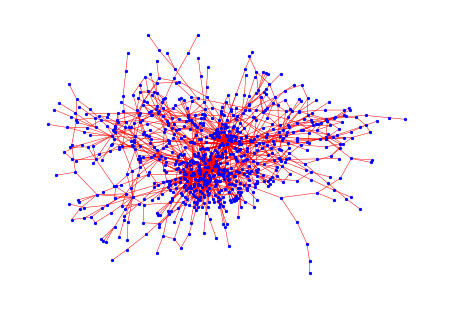

In [11]:
G_CD = Graphp('CD_Adj.npy')
pos = nx.layout.spring_layout(G_CD.G)
nx.draw(G_CD.G,pos=pos,node_color = 'b',edge_color = 'r',with_labels =False,font_size =5,node_size =5,width=0.5)
#plt.show()
plt.savefig('CDGraph.png',dpi=500)
B_CD=G_CD.Betweeness()
C_CD=G_CD.Closeness()

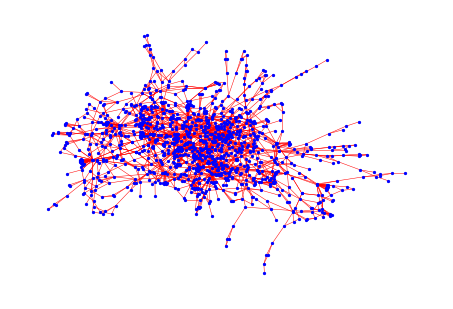

In [12]:
G_SZ = Graphp('SZ_Adj.npy')
pos = nx.layout.spring_layout(G_SZ.G)
nx.draw(G_SZ.G,pos,node_color = 'b',edge_color = 'r',with_labels = False,font_size =5,node_size =5,width=0.5)
#plt.show()
plt.savefig('SZGraph.png',dpi=500)
B_SZ=G_SZ.Betweeness()
C_SZ=G_SZ.Closeness()

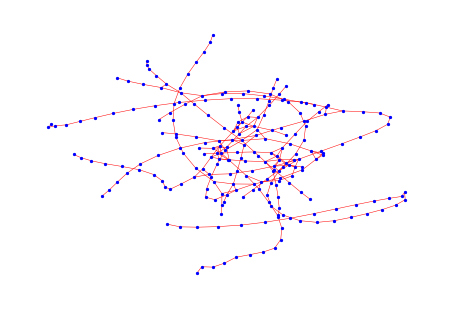

In [13]:
G_P04 = Graphp('P04_Adj.npy')
largest=max(nx.connected_components(G_P04.G),key=len)
GraphP04=G_P04.G.subgraph(largest)
pos = nx.layout.spring_layout(GraphP04)
nx.draw(GraphP04,pos=pos,node_color = 'b',edge_color = 'r',with_labels = False,font_size =15,node_size =5,width=0.5)
#plt.show()
plt.savefig('P04Graph.png',dpi=500)
B_P04=G_P04.Betweeness()
C_P04=G_P04.Closeness()

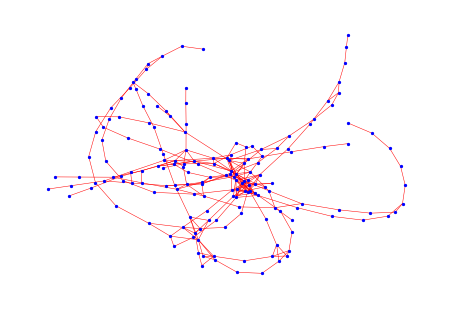

In [14]:
G_P08 = Graphp('P08_Adj.npy')
pos = nx.layout.spring_layout(G_P08.G)
nx.draw(G_P08.G,pos=pos,node_color = 'b',edge_color = 'r',with_labels = False,font_size =15,node_size =5,width=0.5)
#plt.show()
plt.savefig('P08Graph.png',dpi=500)
B_P08=G_P08.Betweeness()
C_P08=G_P08.Closeness()

In [15]:
para=[[1.5,1.9,0.5,0.1]]#Weight

In [16]:
Structural_CD=[]
for i in range(1,len(G_CD.G)+1):
    ego_nodes=get_neigbors(G_CD.G, i, depth=2)
    egograph = G_CD.G.subgraph(ego_nodes)
    e1=nx.density(egograph)
    e2=structuralEntropy(egograph)
    Structural_CD.append([e1,e2,C_CD[i],B_CD[i]])
Structural_CD=np.array(Structural_CD)*para

In [17]:
Structural_SZ=[]
for i in range(1,len(G_SZ.G)+1):
    ego_nodes=get_neigbors(G_SZ.G, i, depth=2)
    egograph = G_SZ.G.subgraph(ego_nodes)
    e1=nx.density(egograph)
    e2=structuralEntropy(egograph)
    Structural_SZ.append([e1,e2,C_SZ[i],B_SZ[i]])
Structural_SZ=np.array(Structural_SZ)*para

In [18]:
Structural_P04=[]
for i in range(1,len(G_P04.G)+1):
    ego_nodes=get_neigbors(G_P04.G, i, depth=2)
    egograph = G_P04.G.subgraph(ego_nodes)
    e1=nx.density(egograph)
    e2=structuralEntropy(egograph)
    Structural_P04.append([e1,e2,C_P04[i],B_P04[i]])
Structural_P04=np.array(Structural_P04)*para
#print(Structural_V)

In [19]:
Structural_P08=[]
for i in range(1,len(G_P08.G)+1):
    ego_nodes=get_neigbors(G_P08.G, i, depth=2)
    egograph = G_P08.G.subgraph(ego_nodes)
    e1=nx.density(egograph)
    e2=structuralEntropy(egograph)
    Structural_P08.append([e1,e2,C_P08[i],B_P08[i]])
Structural_P08=np.array(Structural_P08)*para
#print(Structural_V)

In [20]:
KDtreeSZ = KDTree(Structural_SZ, leaf_size=2)
KDtreeP04 = KDTree(Structural_P04, leaf_size=2)
neighbor_num=3

In [21]:
dist_listCDSZ=np.ndarray((len(Structural_CD),neighbor_num),dtype=int)
neighbor_listCDSZ=np.ndarray((len(Structural_CD),neighbor_num),dtype=int)
for i in range(len(Structural_CD)):
    dist, neighbors = KDtreeSZ.query([Structural_CD[i]], k=neighbor_num)
    dist_listCDSZ[i]=dist
    neighbor_listCDSZ[i]=neighbors
print(neighbor_listCDSZ)

[[   2  915  619]
 [1040 1119 1039]
 [1040 1119 1039]
 ...
 [ 142   25  234]
 [ 106 1125  223]
 [1106  685  660]]


In [22]:
dist_listCDP04=np.ndarray((len(Structural_CD),neighbor_num),dtype=int)
neighbor_listCDP04=np.ndarray((len(Structural_CD),neighbor_num),dtype=int)
for i in range(len(Structural_CD)):
    dist, neighbors = KDtreeP04.query([Structural_CD[i]], k=neighbor_num)
    dist_listCDP04[i]=dist
    neighbor_listCDP04[i]=neighbors
print(neighbor_listCDP04)

[[146 127 208]
 [104   1  57]
 [104   1  57]
 ...
 [232 203  13]
 [249 146 127]
 [104 127 146]]


In [23]:
dist_listP08P04=np.ndarray((len(Structural_P08),neighbor_num),dtype=int)
neighbor_listP08P04=np.ndarray((len(Structural_P08),neighbor_num),dtype=int)
for i in range(len(Structural_P08)):
    dist, neighbors = KDtreeP04.query([Structural_P08[i]], k=neighbor_num)
    dist_listP08P04[i]=dist
    neighbor_listP08P04[i]=neighbors
print(neighbor_listP08P04)

[[203  13  50]
 [203  13  50]
 [214  86  92]
 [120  69 250]
 [231 230  27]
 [231  27 230]
 [ 31 217  27]
 [243  36  68]
 [ 70  65  98]
 [115  35  68]
 [ 38 118 207]
 [183 110 184]
 [183  30 184]
 [ 46   1 104]
 [ 54  46 119]
 [231 265  27]
 [ 26 238 150]
 [119 247  47]
 [231 265  27]
 [ 54 119 252]
 [265 135 217]
 [216 246  11]
 [ 54  46 119]
 [242  66 214]
 [ 26 238 150]
 [203  13  50]
 [242  66 214]
 [ 27  31 217]
 [183 110 184]
 [265 119 252]
 [265 119 252]
 [118 207 271]
 [242  66 214]
 [271  33 269]
 [230  27 217]
 [120  69 250]
 [250 215 219]
 [ 57  35 115]
 [231  27 230]
 [119  98  47]
 [ 70  98 116]
 [  1 104  57]
 [ 70  65  98]
 [250 215  67]
 [ 46  54  98]
 [119 252  47]
 [ 70  98 116]
 [258  26 238]
 [  9  10 137]
 [181 236 290]
 [183 110  94]
 [183 110 184]
 [231  27 230]
 [181 290 236]
 [183 110 184]
 [183 110 184]
 [183 110  94]
 [183 110  94]
 [183  30 184]
 [181 236 290]
 [120  69 250]
 [ 33 269 163]
 [119  47 247]
 [203  13  50]
 [183 110  94]
 [249  80 255]
 [183 184 

In [24]:
dist_listP08SZ=np.ndarray((len(Structural_P08),neighbor_num),dtype=int)
neighbor_listP08SZ=np.ndarray((len(Structural_P08),neighbor_num),dtype=int)
for i in range(len(Structural_P08)):
    dist, neighbors = KDtreeSZ.query([Structural_P08[i]], k=neighbor_num)
    dist_listP08SZ[i]=dist
    neighbor_listP08SZ[i]=neighbors
print(neighbor_listP08SZ)

[[ 742  386  628]
 [ 742  386  628]
 [ 249  606  707]
 [ 806  180  831]
 [ 526  874   44]
 [ 526  874   44]
 [ 429  103  827]
 [   8  761 1072]
 [ 605  766   49]
 [1074  890  620]
 [ 286  288  607]
 [ 385  138  137]
 [ 385  138  137]
 [ 923  920  822]
 [ 191  854   98]
 [ 104  429  580]
 [ 383  151  939]
 [ 722  324  989]
 [ 429    7  104]
 [ 191  580   98]
 [   7  429  827]
 [ 279  891  531]
 [  98 1123  191]
 [ 942 1097 1107]
 [ 383  151  939]
 [ 742  386  628]
 [ 942 1097 1107]
 [ 504 1108 1019]
 [ 385  138  137]
 [ 580  104   35]
 [ 580  104   35]
 [ 808  966  887]
 [ 942 1097 1107]
 [ 696 1144  729]
 [ 527  502   44]
 [ 806  180  831]
 [  14  214  806]
 [ 924  349  705]
 [ 429  899    7]
 [ 722  989  184]
 [  49  348  766]
 [   9  127  563]
 [ 605  766   49]
 [  14  214  806]
 [  65  765  688]
 [  35  184 1166]
 [  49  348  182]
 [ 383  151  939]
 [ 672  281  371]
 [ 381  706  900]
 [ 385  138  137]
 [ 385  138  137]
 [ 429   44  511]
 [ 900  706  381]
 [ 385  138  137]
 [ 385  13

In [25]:
data_pems04_f=np.load('PEMS04_f.npy')#nodes, samples
data_pems08_f=np.load('PEMS08_f.npy')
data_pems04_o=np.load('PEMS04_o.npy')
data_pems08_o=np.load('PEMS08_o.npy')
data_pems04_s=np.load('PEMS04_s.npy')
data_pems08_s=np.load('PEMS08_s.npy')
data_CD=np.load('CD_S.npy')
data_SZ=np.load('SZ_S.npy')

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800


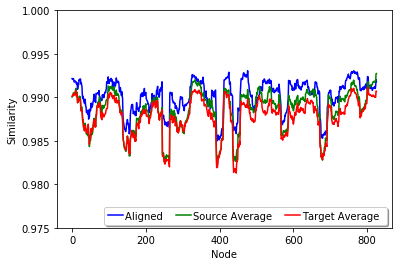

In [26]:
#x=loadData(data_pems08_f,144*1)#datases, sample frequency
#y=loadData(data_pems04_s,144*1)#datases, sample frequency
x=loadData(data_CD,144*2)#datases, sample frequency
y=loadData(data_SZ,144*2)#datases, sample frequency
#x, y = fre_uni(x, y)
remove = open('roadSim_CDSZ.csv', "r+")  
remove.truncate()
for i in range(0,len(x)):
    if i%50==0:
        print(i)
    re=[]
    dataCD_cluster0 = x[i].reshape(1,-1)
    dataSZ_cluster0 = y[neighbor_listCDSZ[i]].reshape(neighbor_num,-1)
    dataCD_cluster0,dataSZ_cluster0=timestamp_alignment(dataCD_cluster0,dataSZ_cluster0)
    Sim=Simcaculate(dataCD_cluster0,dataSZ_cluster0)
    re.append(Sim)
    
    dataCD_cluster1 = y
    dataCD_cluster0,dataCD_cluster1=timestamp_alignment(dataCD_cluster0,dataCD_cluster1)
    Sim=Simcaculate(dataCD_cluster0,dataCD_cluster1)
    re.append(Sim)
    
    dataCD_cluster2 = x
    dataCD_cluster0,dataCD_cluster1=timestamp_alignment(dataCD_cluster0,dataCD_cluster2)
    Sim=Simcaculate(dataCD_cluster0,dataCD_cluster2)
    re.append(Sim)
    
    with open('roadSim_CDSZ.csv','a+',newline='') as f1:
        writer=csv.writer(f1)
        writer.writerow(re)
data1=np.loadtxt(open("roadSim_CDSZ.csv","rb"),delimiter=",",skiprows=0)  
plot(moving_average(data1.T,20,1),'CDSZ_{}.png' .format(neighbor_num),0.975)

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800


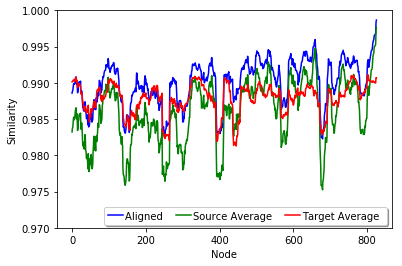

In [27]:
#x=loadData(data_pems08_f,144*1)#datases, sample frequency
y=loadData(data_pems04_s,144*1)#datases, sample frequency
x=loadData(data_CD,144*2)#datases, sample frequency
#y=loadData(data_SZ,144*2)#datases, sample frequency
x, y = fre_uni(x, y)
x,y=timestamp_alignment(x,y,1)
remove = open('roadSim_CDP04.csv', "r+")  
remove.truncate()
for i in range(0,len(x)):
    if i%50==0:
        print(i)
    re=[]
    dataCD_cluster0 = x[i].reshape(1,-1)
    dataSZ_cluster0 = y[neighbor_listCDP04[i]].reshape(neighbor_num,-1)
    Sim=Simcaculate(dataCD_cluster0,dataSZ_cluster0)
    re.append(Sim)
    
    dataCD_cluster1 = y
    Sim=Simcaculate(dataCD_cluster0,dataCD_cluster1)
    re.append(Sim)
    
    dataCD_cluster2 = x
    Sim=Simcaculate(dataCD_cluster0,dataCD_cluster2)
    re.append(Sim)
    
    with open('roadSim_CDP04.csv','a+',newline='') as f1:
        writer=csv.writer(f1)
        writer.writerow(re)
data1=np.loadtxt(open("roadSim_CDP04.csv","rb"),delimiter=",",skiprows=0)  
plot(moving_average(data1.T,20,1),'CDP04_{}.png' .format(neighbor_num),0.97)

0
50
100
150


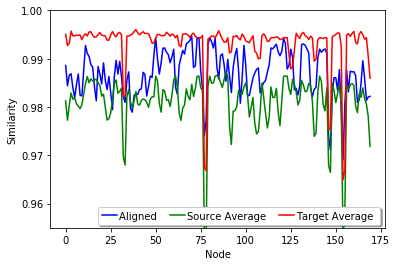

In [28]:
x=loadData(data_pems08_f,144*1)#datases, sample frequency
y=loadData(data_pems04_f,144*1)#datases, sample frequency
#x=loadData(data_CD,144*2)#datases, sample frequency
#y=loadData(data_SZ,144*2)#datases, sample frequency
x, y = fre_uni(x, y)
x,y=timestamp_alignment(x,y)
remove = open('roadSim_P08P04.csv', "r+")  
remove.truncate()
for i in range(0,len(x)):
    if i%50==0:
        print(i)
    re=[]
    dataCD_cluster0 = x[i].reshape(1,-1)
    dataSZ_cluster0 = y[neighbor_listP08P04[i]].reshape(neighbor_num,-1)
    Sim=Simcaculate(dataCD_cluster0,dataSZ_cluster0)
    re.append(Sim)
    
    dataCD_cluster1 = y
    Sim=Simcaculate(dataCD_cluster0,dataCD_cluster1)
    re.append(Sim)
    
    dataCD_cluster2 = x
    Sim=Simcaculate(dataCD_cluster0,dataCD_cluster2)
    re.append(Sim)
    
    with open('roadSim_P08P04.csv','a+',newline='') as f1:
        writer=csv.writer(f1)
        writer.writerow(re)
data1=np.loadtxt(open("roadSim_P08P04.csv","rb"),delimiter=",",skiprows=0)  
plot(moving_average(data1.T,2,1),'P08P04_{}.png' .format(neighbor_num),0.955)

0
50
100
150


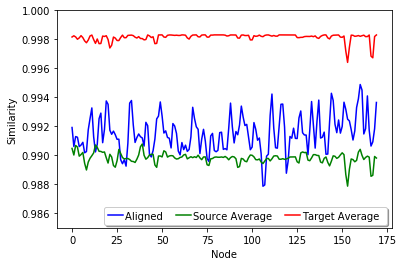

In [29]:
x=loadData(data_pems08_s,144*1)#datases, sample frequency
#y=loadData(data_pems04_s,144*1)#datases, sample frequency
#x=loadData(data_CD,144*2)#datases, sample frequency
y=loadData(data_SZ,144*2)#datases, sample frequency
x, y = fre_uni(x, y)
x,y=timestamp_alignment(x,y,1)
remove = open('roadSim_P08SZ.csv', "r+")  
remove.truncate()
for i in range(0,len(x)):
    if i%50==0:
        print(i)
    re=[]
    dataCD_cluster0 = x[i].reshape(1,-1)
    dataSZ_cluster0 = y[neighbor_listCDP04[i]].reshape(neighbor_num,-1)
    Sim=Simcaculate(dataCD_cluster0,dataSZ_cluster0
    re.append(Sim)
    
    dataCD_cluster1 = y
    Sim=Simcaculate(dataCD_cluster0,dataCD_cluster1)
    re.append(Sim)
    
    dataCD_cluster2 = x
    Sim=Simcaculate(dataCD_cluster0,dataCD_cluster2)
    re.append(Sim)
    
    with open('roadSim_P08SZ.csv','a+',newline='') as f1:
        writer=csv.writer(f1)
        writer.writerow(re)
data1=np.loadtxt(open("roadSim_P08SZ.csv","rb"),delimiter=",",skiprows=0)  
plot(moving_average(data1.T,2,1),'P08SZ_{}.png' .format(neighbor_num),0.985)